**Loading an edge-list of Zachary's karate club dataset from a CSV file:** We load each edge and we build a scipy.sparse.csr_matrix 
 

In [1]:
import pkg_resources
import csv
import scipy.sparse

karate_csv_file_path = pkg_resources.resource_filename("gvnr", "resources/karate_edges.csv")
csr_data = list()
csr_rows = list()
csr_cols = list()
with open(karate_csv_file_path, newline='') as csvfile:
        csvfile.readline() 
        csv_reader = csv.reader(csvfile, delimiter=',')
        for csv_row in csv_reader:
            csr_data.append(1)
            csr_rows.append(int(csv_row[0])-1)
            csr_cols.append(int(csv_row[1])-1)
            
num_nodes = max(max(csr_rows), max(csr_cols))+1
adjacency_matrix = scipy.sparse.csr_matrix((csr_data, (csr_rows, csr_cols)), shape=(num_nodes, num_nodes))
adjacency_matrix+=adjacency_matrix.T  # we make the network undirected

print(adjacency_matrix.todense()[0:5,0:5])

[[0 1 1 1 1]
 [1 0 1 1 0]
 [1 1 0 1 0]
 [1 1 1 0 0]
 [1 0 0 0 0]]


**Running random walks, sliding a window over the generated paths and building a co-occurrence count matrix**

In [3]:
import gvnr.preprocessing.random_walker
import gvnr.preprocessing.window_slider

random_walker = gvnr.preprocessing.random_walker.RandomWalker(
                adjacency_matrix,
                walks_length=4,
                walks_number=50
            )
random_walks = random_walker.build_random_walks()

slider = gvnr.preprocessing.window_slider.WindowSlider(
    random_walks,
    adjacency_matrix.shape[0],
    window_size=3,
    window_factor="decreasing"
)
X = slider.build_cooccurrence_matrix()

print( f"{len(X.data)*100 / (num_nodes*num_nodes):.2f}% dense")
print( f"mean {X.mean()}")

print(X.todense()[0:5,0:5])

70.33% dense
mean 15.32641291810842
[[106.5        131.         100.         116.83333333 102.33333333]
 [137.33333333  43.          94.16666667  89.16666667   2.33333333]
 [104.66666667  95.83333333  30.5         73.5          1.83333333]
 [112.33333333  88.66666667  72.33333333  26.66666667   4.        ]
 [104.83333333   2.66666667   3.16666667   4.83333333  13.33333333]]


**Running GVNR on X and getting the learned embeddings (I and J)**

In [5]:
import gvnr.models.gvnr

import scipy.sparse

model = gvnr.models.gvnr.gvnr()
model.fit(X,
          learn_rate=0.003,
          embedding_size=2,
          batch_size=1,
          n_epochs=10,
          k_neg=1,
          x_min=15
          )

embeddings_I = model.get_embeddings(embedding='I')
embeddings_J = model.get_embeddings(embedding='J')
print(embeddings_I.shape)
print(embeddings_J.shape)

(34, 2)
(34, 2)


**Some random visualizations of the learned embeddings**

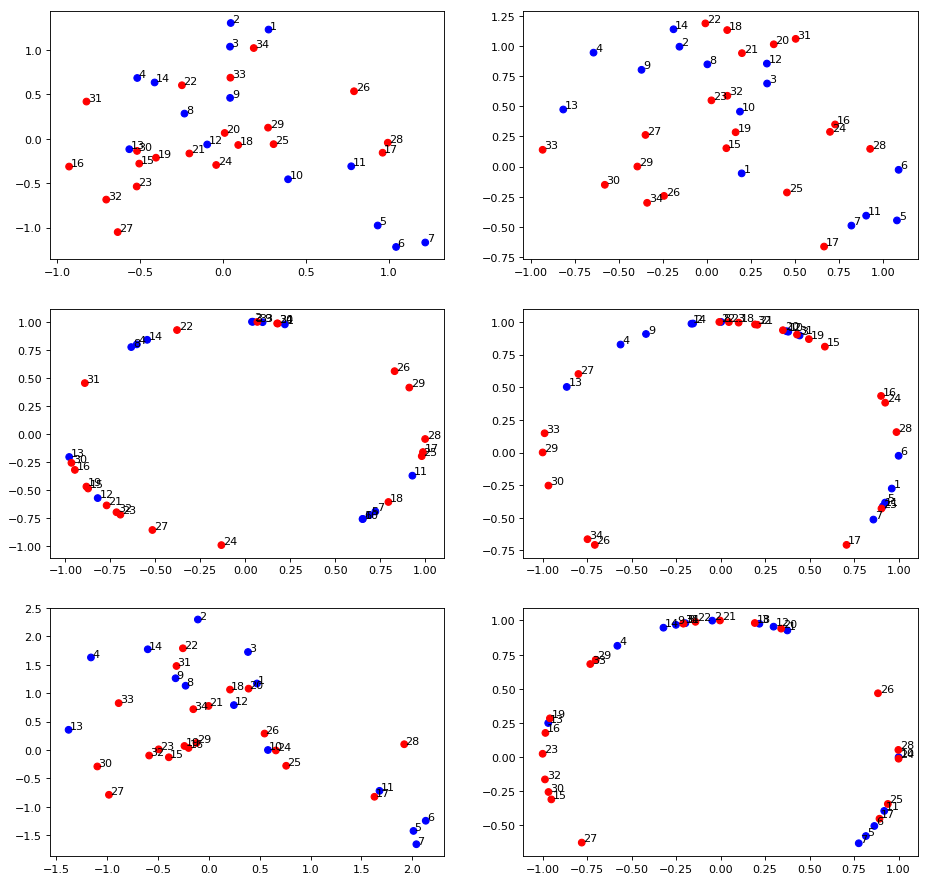

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import normalize

c = ['b' if i<14 else 'r' for i in range(num_nodes)]

plt.figure(num=None, figsize=(14, 14), dpi=80)

plt.subplot(321)
xs = embeddings_I[:,0]
ys = embeddings_I[:,1]
plt.scatter(xs, ys, marker="o", c=c)
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.text(x+0.01, y+0.01, str(i+1),  fontsize=10)

plt.subplot(322)
xs = embeddings_J[:,0]
ys = embeddings_J[:,1]
plt.scatter(xs, ys, marker="o", c=c)
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.text(x+0.01, y+0.01, str(i+1),  fontsize=10)
    
plt.subplot(323)
xs = normalize(embeddings_I)[:,0]
ys = normalize(embeddings_I)[:,1]
plt.scatter(xs, ys, marker="o", c=c)
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.text(x+0.01, y+0.01, str(i+1),  fontsize=10)

plt.subplot(324)
xs = normalize(embeddings_J)[:,0]
ys = normalize(embeddings_J)[:,1]
plt.scatter(xs, ys, marker="o", c=c)
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.text(x+0.01, y+0.01, str(i+1),  fontsize=10)

plt.subplot(325)
xs = (embeddings_J + embeddings_I)[:,0]
ys = (embeddings_J + embeddings_I)[:,1]
plt.scatter(xs, ys, marker="o", c=c)
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.text(x+0.01, y+0.01, str(i+1),  fontsize=10)
    
plt.subplot(326)
xs = normalize((embeddings_J + embeddings_I), axis=1)[:,0]
ys = normalize((embeddings_J + embeddings_I), axis=1)[:,1]
plt.scatter(xs, ys, marker="o", c=c)
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.text(x+0.01, y+0.01, str(i+1),  fontsize=10)
